# Classification with Python

In [1]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

## Download and read the dataset

In [2]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2020-06-25 01:28:46--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

100%[======================================>] 23,101      --.-K/s   in 0.001s  

2020-06-25 01:28:46 (17.2 MB/s) - ‘loan_train.csv’ saved [23101/23101]



In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

## Convert to date time object

In [5]:
df['effective_date'] = pd.to_datetime(df['effective_date'])
df['due_date'] = pd.to_datetime(df['due_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visulisation and analysis

In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

In [7]:
df['Principal'].value_counts()

1000    258
800      81
300       3
500       2
900       2
Name: Principal, dtype: int64

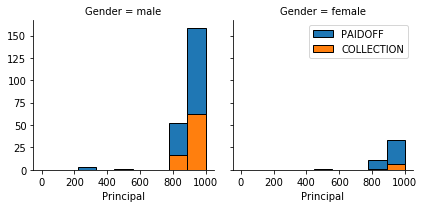

In [8]:
g = sns.FacetGrid(df, col='Gender', hue='loan_status', col_wrap=2)
g.map(plt.hist, 'Principal', bins=np.linspace(0, df.Principal.max(), 10), ec='k')
g.axes[-1].legend()
plt.show()

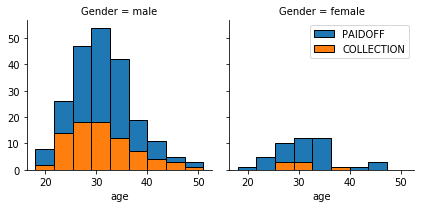

In [9]:
g = sns.FacetGrid(df, col='Gender', hue='loan_status', col_wrap=2)
g.map(plt.hist, 'age', bins=np.linspace(df.age.min(), df.age.max(), 10), ec='k')
g.axes[-1].legend()
plt.show()

## Pre-processing: Feature selection/extraction

## The day of the week people get the loan

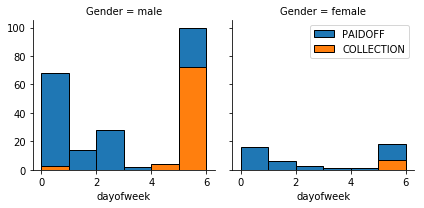

In [10]:
df['dayofweek'] = df['effective_date'].dt.dayofweek

g = sns.FacetGrid(df, col="Gender", hue="loan_status", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=np.linspace(0,6,7), ec="k") # Monday=0, Sunday=6
g.axes[-1].legend()
plt.show()

According to the histogram above, people who get the loan on weekends seem more likely to default on loans, so we divide the days of week into two groups: 1 stands for Friday, Satturday, and Sunday, and 0 stands for the rest

In [11]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x > 3) else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

In [12]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

convert male to 0 and female to 1

In [13]:
df['Gender'].replace(to_replace = ['male', 'female'], value = [0, 1], inplace = True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


In [14]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

Feature before One Hot Encoding

In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature.head()

,Principal,terms,age,Gender,weekend
0,1000,30,45,0,0
1,1000,30,33,1,0
2,1000,15,27,0,0
3,1000,30,28,1,1
4,1000,30,29,0,1


In [16]:
Feature = pd.concat([Feature, pd.get_dummies(df['education'])], axis = 1)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


## Feature selection

In [17]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,Master or Above,college
0,1000,30,45,0,0,0,1,0,0
1,1000,30,33,1,0,1,0,0,0
2,1000,15,27,0,0,0,0,0,1
3,1000,30,28,1,1,0,0,0,1
4,1000,30,29,0,1,0,0,0,1


In [18]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Train Test Split

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (276, 9) (276,)
Test set: (70, 9) (70,)


## Normalise data

Data Standardisation give data zero mean and unit variance (technically should be done after train test split )

In [21]:
X = preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:1: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  if __name__ == '__main__':


array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.07624929, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.07624929, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669, -0.07624929,  1.14984679]])

## Classification

## K Nearest Neighbor

In [22]:
from sklearn.neighbors import KNeighborsClassifier

## Training

Lets start the algorithm with k=4 for now.

In [23]:
k = 4
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=4, p=2,
           weights='uniform')

## Predicting

Use the model to predict the test set.

In [24]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

## Accuracy evaluation

In [25]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.822463768115942
Test set Accuracy:  0.6


In [26]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.61428571, 0.54285714, 0.68571429, 0.6       , 0.72857143,
       0.68571429, 0.68571429, 0.68571429, 0.74285714, 0.7       ,
       0.72857143, 0.72857143, 0.72857143, 0.71428571, 0.72857143,
       0.72857143, 0.74285714, 0.71428571, 0.74285714])

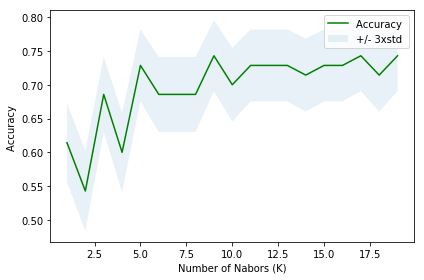

In [27]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.1)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Nabors (K)')
plt.tight_layout()
plt.show()

In [28]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.7428571428571429 with k= 9


### Rebuild the model with optimal K

In [29]:
k = mean_acc.argmax()+1
#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
neigh

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=9, p=2,
           weights='uniform')

In [30]:
yhat = neigh.predict(X_test)
yhat[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

In [31]:
from sklearn import metrics
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.7717391304347826
Test set Accuracy:  0.7428571428571429


## Accuracy evaluation

In [32]:
from sklearn.metrics import classification_report, confusion_matrix

In [33]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

  COLLECTION       0.20      0.07      0.10        15
     PAIDOFF       0.78      0.93      0.85        55

   micro avg       0.74      0.74      0.74        70
   macro avg       0.49      0.50      0.48        70
weighted avg       0.66      0.74      0.69        70

Confusion matrix, without normalization
[[ 1 14]
 [ 4 51]]


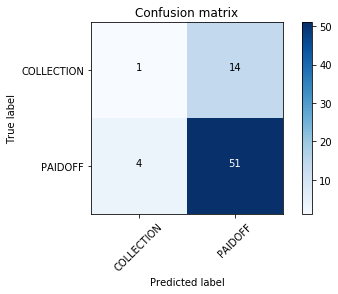

In [34]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

### Jaccard index

In [35]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(y_test, yhat)

0.7428571428571429

### F1-score

In [36]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.6892857142857144

## Decision Tree

In [37]:
from sklearn.tree import DecisionTreeClassifier

In [38]:
Ds = 10
mean_acc = np.zeros((Ds-1))
std_acc = np.zeros((Ds-1))
for n in range(1,Ds):
    
    #Train Model and Predict  
    loan_tree = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    yhat=loan_tree.predict(X_test)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.79, 0.79, 0.61, 0.61, 0.64, 0.77, 0.76, 0.76, 0.64])

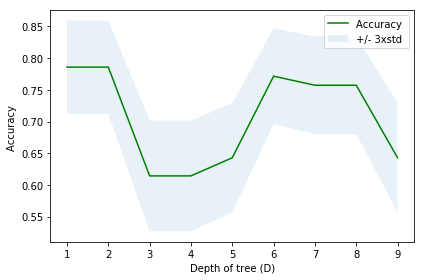

The best accuracy was with 0.7857142857142857 with d= 1


In [39]:
plt.plot(range(1,Ds),mean_acc,'g')
plt.fill_between(range(1,Ds),mean_acc - 1.5 * std_acc,mean_acc + 1.5 * std_acc, alpha=0.1)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth of tree (D)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with d=", mean_acc.argmax()+1) 

In [40]:
loan_tree = DecisionTreeClassifier(criterion="entropy", max_depth = mean_acc.argmax()+1)

In [41]:
loan_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
pred_tree = loan_tree.predict(X_test)

In [43]:
print (pred_tree[0:5])
print (y_test[0:5])

['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']


## Evaluation

In [44]:
from sklearn import metrics
import matplotlib.pyplot as plt
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, pred_tree))

DecisionTrees's Accuracy:  0.7857142857142857


### Confusion matrix

              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


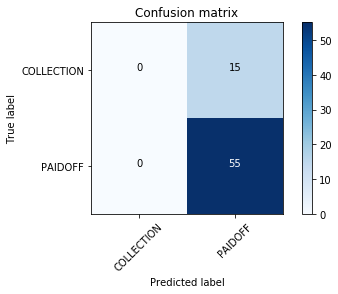

In [45]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, pred_tree, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, pred_tree))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

### Jaccard index

In [46]:
jaccard_similarity_score(y_test, pred_tree)

0.7857142857142857

### F1-score

In [47]:
f1_score(y_test, pred_tree, average='weighted') 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


0.6914285714285714

## Support Vector Machine

In [48]:
from sklearn import svm

In [52]:
loan = svm.SVC(kernel='rbf', gamma='auto')
loan.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
y_svm = loan.predict(X_test)
y_svm[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'COLLECTION', 'PAIDOFF'],
      dtype=object)

### Confusion matrix

              precision    recall  f1-score   support

  COLLECTION       0.25      0.07      0.11        15
     PAIDOFF       0.79      0.95      0.86        55

   micro avg       0.76      0.76      0.76        70
   macro avg       0.52      0.51      0.48        70
weighted avg       0.67      0.76      0.70        70

Confusion matrix, without normalization
[[ 1 14]
 [ 3 52]]


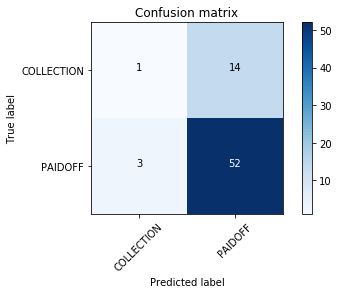

In [54]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_svm, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_svm))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

### Jaccard index

In [55]:
jaccard_similarity_score(y_test, y_svm)

0.7571428571428571

### F1-score

In [56]:
f1_score(y_test, y_svm, average='weighted') 

0.6978810663021189

## Logistic Regression

In [57]:
from sklearn.linear_model import LogisticRegression

In [59]:
Cs = 10
mean_acc = np.zeros((Cs-1))
std_acc = np.zeros((Cs-1))
for n in range(1,Cs):
    
    #Train Model and Predict  
    LR = LogisticRegression(C=0.01*n, solver='lbfgs').fit(X_train,y_train)
    yhat=LR.predict(X_test)
    
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.79, 0.77])

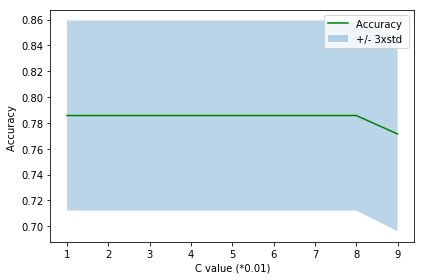

The best accuracy was with 0.7857142857142857 with C= 0.01


In [60]:
plt.plot(range(1,Cs),mean_acc,'g')
plt.fill_between(range(1,Cs),mean_acc - 1.5 * std_acc,mean_acc + 1.5 * std_acc, alpha=0.30)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('C value (*0.01)')
plt.tight_layout()
plt.show()
print( "The best accuracy was with", mean_acc.max(), "with C=", (mean_acc.argmax()+1)*0.01)

In [61]:
LR = LogisticRegression(C=(mean_acc.argmax()+1)*0.01, solver='liblinear').fit(X_train,y_train)
LR

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [62]:
y_LR = LR.predict(X_test)

In [63]:
y_LR_prob = LR.predict_proba(X_test)

### Confusion matrix

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

  COLLECTION       0.00      0.00      0.00        15
     PAIDOFF       0.79      1.00      0.88        55

   micro avg       0.79      0.79      0.79        70
   macro avg       0.39      0.50      0.44        70
weighted avg       0.62      0.79      0.69        70

Confusion matrix, without normalization
[[ 0 15]
 [ 0 55]]


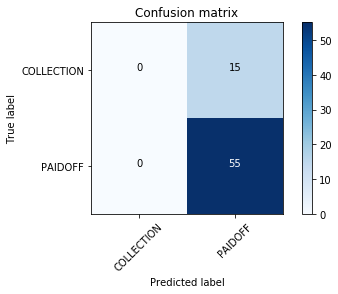

In [64]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_LR, labels=['COLLECTION', 'PAIDOFF'])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_LR))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['COLLECTION', 'PAIDOFF'],normalize= False,  title='Confusion matrix')

### Jaccard index

In [ ]:
jaccard_similarity_score(y_test, y_LR)

## F1-score

In [ ]:
f1_score(y_test, y_LR, average='weighted') 

## log loss

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_test, y_LR_prob)

## Model Evaluation using Test set

In [ ]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

In [ ]:
df_test = pd.read_csv('loan_test.csv')
df_test.head()

In [ ]:
# convert to date time object
df_test['effective_date'] = pd.to_datetime(df_test['effective_date'])
df_test['due_date'] = pd.to_datetime(df_test['due_date'])

df_test['dayofweek'] = df_test['effective_date'].dt.dayofweek
df_test['weekend'] = df_test['dayofweek'].apply(lambda x: 1 if (x > 3) else 0)
df_test['Gender'].replace(to_replace = ['male', 'female'], value = [0, 1], inplace = True)

Feature_test = df_test[['Principal','terms','age','Gender','weekend']]

Feature_test = pd.concat([Feature_test, pd.get_dummies(df_test['education'])], axis = 1)

Feature_test.head()

In [ ]:
X_testset = preprocessing.StandardScaler().fit(Feature_test).transform(Feature_test)
X_testset[0:5]

In [ ]:
y_testset = df_test['loan_status'].values
y_testset[0:5]

## KNN Evaluation

In [ ]:
yhat_test = neigh.predict(X_testset)
print('KNN Jaccard index: {:.2f}'.format(jaccard_similarity_score(y_testset, yhat_test)))
print('KNN F1-score: {:.2f}'.format(f1_score(y_testset, yhat_test, average='weighted')))

## Decision Tree Evaluation

In [ ]:
tree_test = loan_tree.predict(X_testset)
print('Decision Tree Jaccard index: {:.2f}'.format(jaccard_similarity_score(y_testset, tree_test)))
print('Decision Tree F1-score: {:.2f}'.format(f1_score(y_testset, tree_test, average='weighted')))

## SVM Evaluation

In [ ]:
loan_test = loan.predict(X_testset)
print('SVM Jaccard index: {:.2f}'.format(jaccard_similarity_score(y_testset, tree_test)))
print('SVM F1-score: {:.2f}'.format(f1_score(y_testset, tree_test, average='weighted')))

## Logistic Regression Evaluation

In [ ]:
LR_test = LR.predict(X_testset)
LR_test_prob = LR.predict_proba(X_testset)
print('LR Jaccard index: {:.2f}'.format(jaccard_similarity_score(y_testset, LR_test)))
print('LR F1-score: {:.2f}'.format(f1_score(y_testset, LR_test, average='weighted')))
print('LR F1-score: {:.2f}'.format(log_loss(y_testset, LR_test_prob)))

## Report